In [29]:
import tensorflow as tf
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Conv2DTranspose, concatenate, BatchNormalization, ReLU, LeakyReLU
from keras import Model
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os

# Define the base path to your dataset
base_path = "/content/drive/MyDrive/carla-capture-20180513A"

# Define directories for images and masks
image_dir = os.path.join(base_path, "CameraRGB")
mask_dir = os.path.join(base_path, "CameraSeg")  # Assuming masks are stored in "CameraSeg"

# List all image and mask files
image_paths = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir)]

# Count the total number of images and masks
total_images, total_masks = len(image_paths), len(mask_paths)
print(f"Total Images: {total_images}, Total Masks: {total_masks}")

# Print examples of image and mask paths
if total_images > 0 and total_masks > 0:
    print("Eg. of image: ", image_paths[0])
    print("Eg. of mask:  ", mask_paths[0])
else:
    print("No images or masks found.")


Total Images: 1000, Total Masks: 1000
Eg. of image:  /content/drive/MyDrive/carla-capture-20180513A/CameraRGB/F61-2.png
Eg. of mask:   /content/drive/MyDrive/carla-capture-20180513A/CameraSeg/F67-16.png


(-0.5, 799.5, 599.5, -0.5)

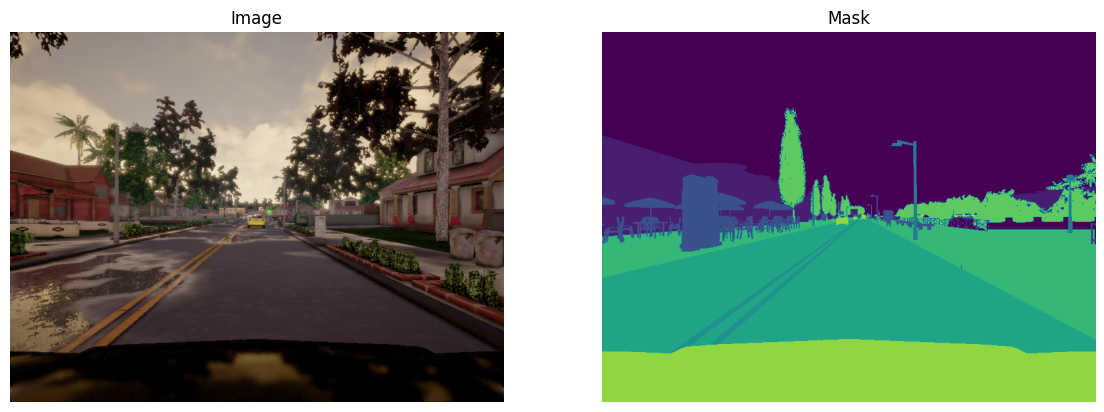

In [31]:
import imageio
N = 4

sample_img = imageio.v3.imread(image_paths[N])

sample_mask = imageio.v3.imread(mask_paths[N])
sample_mask = np.array([max(sample_mask[i, j]) for i in range(sample_mask.shape[0]) for j in range(sample_mask.shape[1])])
sample_mask = sample_mask.reshape(sample_img.shape[0], sample_img.shape[1])
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(sample_img)
arr[0].set_title("Image")
arr[0].axis("off")
arr[1].imshow(sample_mask)
arr[1].set_title( "Mask")
arr[1].axis("off")

In [32]:
from sklearn.model_selection import train_test_split
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size = 0.2, random_state = 42)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, test_size = 0.2, random_state = 42)

print("Train Size: ", len(train_image_paths))
print("Validation Size: ", len(val_image_paths))
print("Test Size: ", len(test_image_paths))

Train Size:  800
Validation Size:  160
Test Size:  40


In [33]:
def read_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (192, 256), method = "nearest")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 3)
    mask = tf.math.reduce_max(mask, axis = -1, keepdims = True)
    mask = tf.image.resize(mask, (192, 256), method = "nearest")

    return image, mask


def generate_dataset(image_paths, mask_paths, buffer_size, batch_size):
    image_list = tf.constant(image_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)

    return dataset

In [34]:
buffer_size = 1000
batch_size = 64

train_dataset = generate_dataset(train_image_paths, train_mask_paths, buffer_size, batch_size)
val_dataset = generate_dataset(val_image_paths, val_mask_paths, buffer_size, batch_size)
test_dataset = generate_dataset(test_image_paths, test_mask_paths, buffer_size, batch_size)

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 47 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

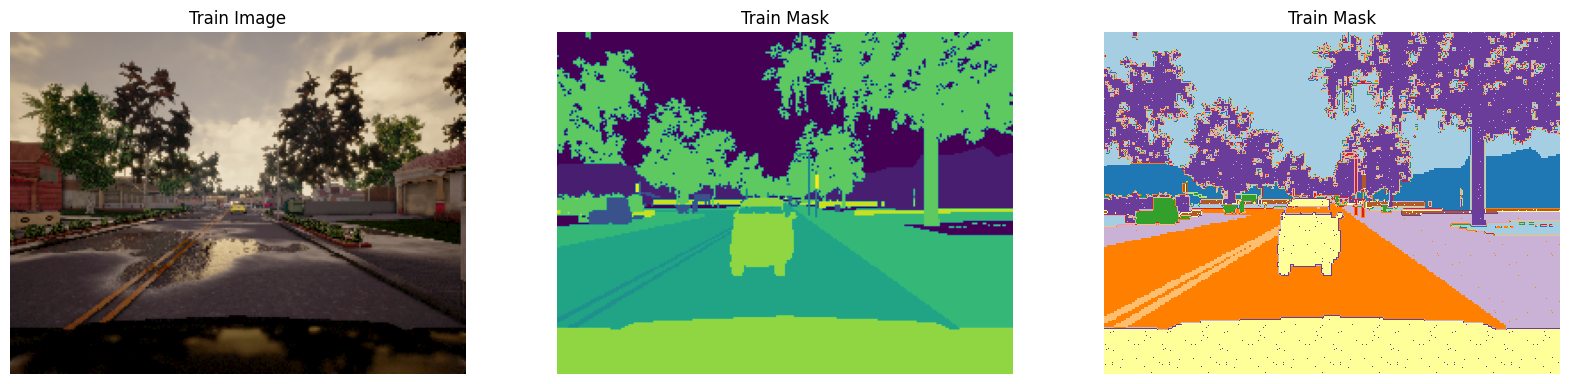

In [35]:
import random
for train_images, train_masks in train_dataset:
    break

for val_images, val_masks in val_dataset:
    break

for test_images, test_masks in test_dataset:
    break

for i in range(3):
    N = random.randint(0, batch_size-1)

    images = [train_images[N], val_images[N], test_images[N]]
    masks = [train_masks[N], val_masks[N], test_masks[N]]
    titles = ["Train Image", "Validation Image", "Test Image", "Train Mask", "Validation Mask", "Test Mask"]

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(images[i])
    arr[0].set_title(titles[i])
    arr[0].axis("off")

    arr[1].imshow(masks[i])
    arr[1].set_title(titles[i+3])
    arr[1].axis("off")

    arr[2].imshow(masks[i], cmap = "Paired")
    arr[2].set_title(titles[i+3])
    arr[2].axis("off")

In [36]:
def conv_block(inputs = None, n_filters = 32, dropout = 0, max_pooling = True):
    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)

    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(layer)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)

    if dropout > 0:
        layer = Dropout(dropout)(layer)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2, 2))(layer)
    else:
        next_layer = layer

    skip_connection = layer

    return next_layer, skip_connection

In [37]:
def up_block(expansive_input, contractive_input, n_filters = 32):
    up = Conv2DTranspose(n_filters, 3, strides = (2, 2), padding = 'same')(expansive_input)
    merge = concatenate([up, contractive_input], axis = 3)

    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(merge)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)

    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(layer)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)

    return layer

In [38]:
def unet_model(input_size = (96, 128, 3), n_filters = 32, n_classes = 13):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout = 0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout = 0.3, max_pooling = False)

    ublock6 = up_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = up_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = up_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = up_block(ublock8, cblock1[1], n_filters)

    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(ublock9)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)

    layer = Conv2D(n_classes, 1, padding = 'same')(layer)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)

    model = Model(inputs = inputs, outputs = layer)
    return model

In [39]:
img_size = (192, 256, 3)
unet_model = unet_model(img_size)

unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 192, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 192, 256, 32)   │          9,248 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 256, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 192, 256, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 128, 32)    │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 128, 64)    │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 128, 64)    │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 96, 128, 64)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 96, 128, 64)    │         36,928 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 128, 64)    │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 96, 128, 64)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 64, 64)     │              0 │ leaky_re_lu_3[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 48, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 8,652,097 (33.01 MB)

 Trainable params: 8,646,119 (32.98 MB)

 Non-trainable params: 5,978 (23.35 KB)

In [40]:
unet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

epochs = 20
batch_size = 256
early_stop = tf.keras.callbacks.EarlyStopping(patience = 2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.1, patience = 1, min_lr = 1e-6)

history = unet_model.fit(train_dataset, validation_data = val_dataset, verbose = 1, batch_size = batch_size, epochs = epochs, callbacks = [early_stop, reduce_lr])

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.3271 - loss: 2.2693 - val_accuracy: 0.2372 - val_loss: 207.0648 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6409 - loss: 1.6976 - val_accuracy: 0.2145 - val_loss: 91.4412 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6900 - loss: 1.5427 - val_accuracy: 0.3176 - val_loss: 18.2546 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7214 - loss: 1.4526 - val_accuracy: 0.4419 - val_loss: 4.6607 - learning_rate: 0.0010
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7236 - loss: 1.4131 - val_accuracy: 0.6199 - val_loss: 2.3622 - learning_rate: 0.0010
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7263 - loss: 1.3732 - val_accuracy: 0.6158 - val_loss: 2.3325 - learning_rate: 0.0010
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7287 - loss: 1.3429 - val_accur

In [42]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

unet_model.save('unet-carla-segmentation.keras')

In [43]:
with open('history.pkl', 'rb') as f:
    history = pickle.load(f)

print(history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [44]:
def plot_history(history):
    acc = [0.] + history['accuracy']
    val_acc = [0.] + history['val_accuracy']

    loss = [0.] + history['loss']
    val_loss = [0.] + history['val_loss']

    plt.figure(figsize=(20, 16))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower right')
    plt.ylim([min(plt.ylim()), 1])
    plt.plot()

    plt.subplot(2, 1, 2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend(loc = 'upper right')
    plt.plot()

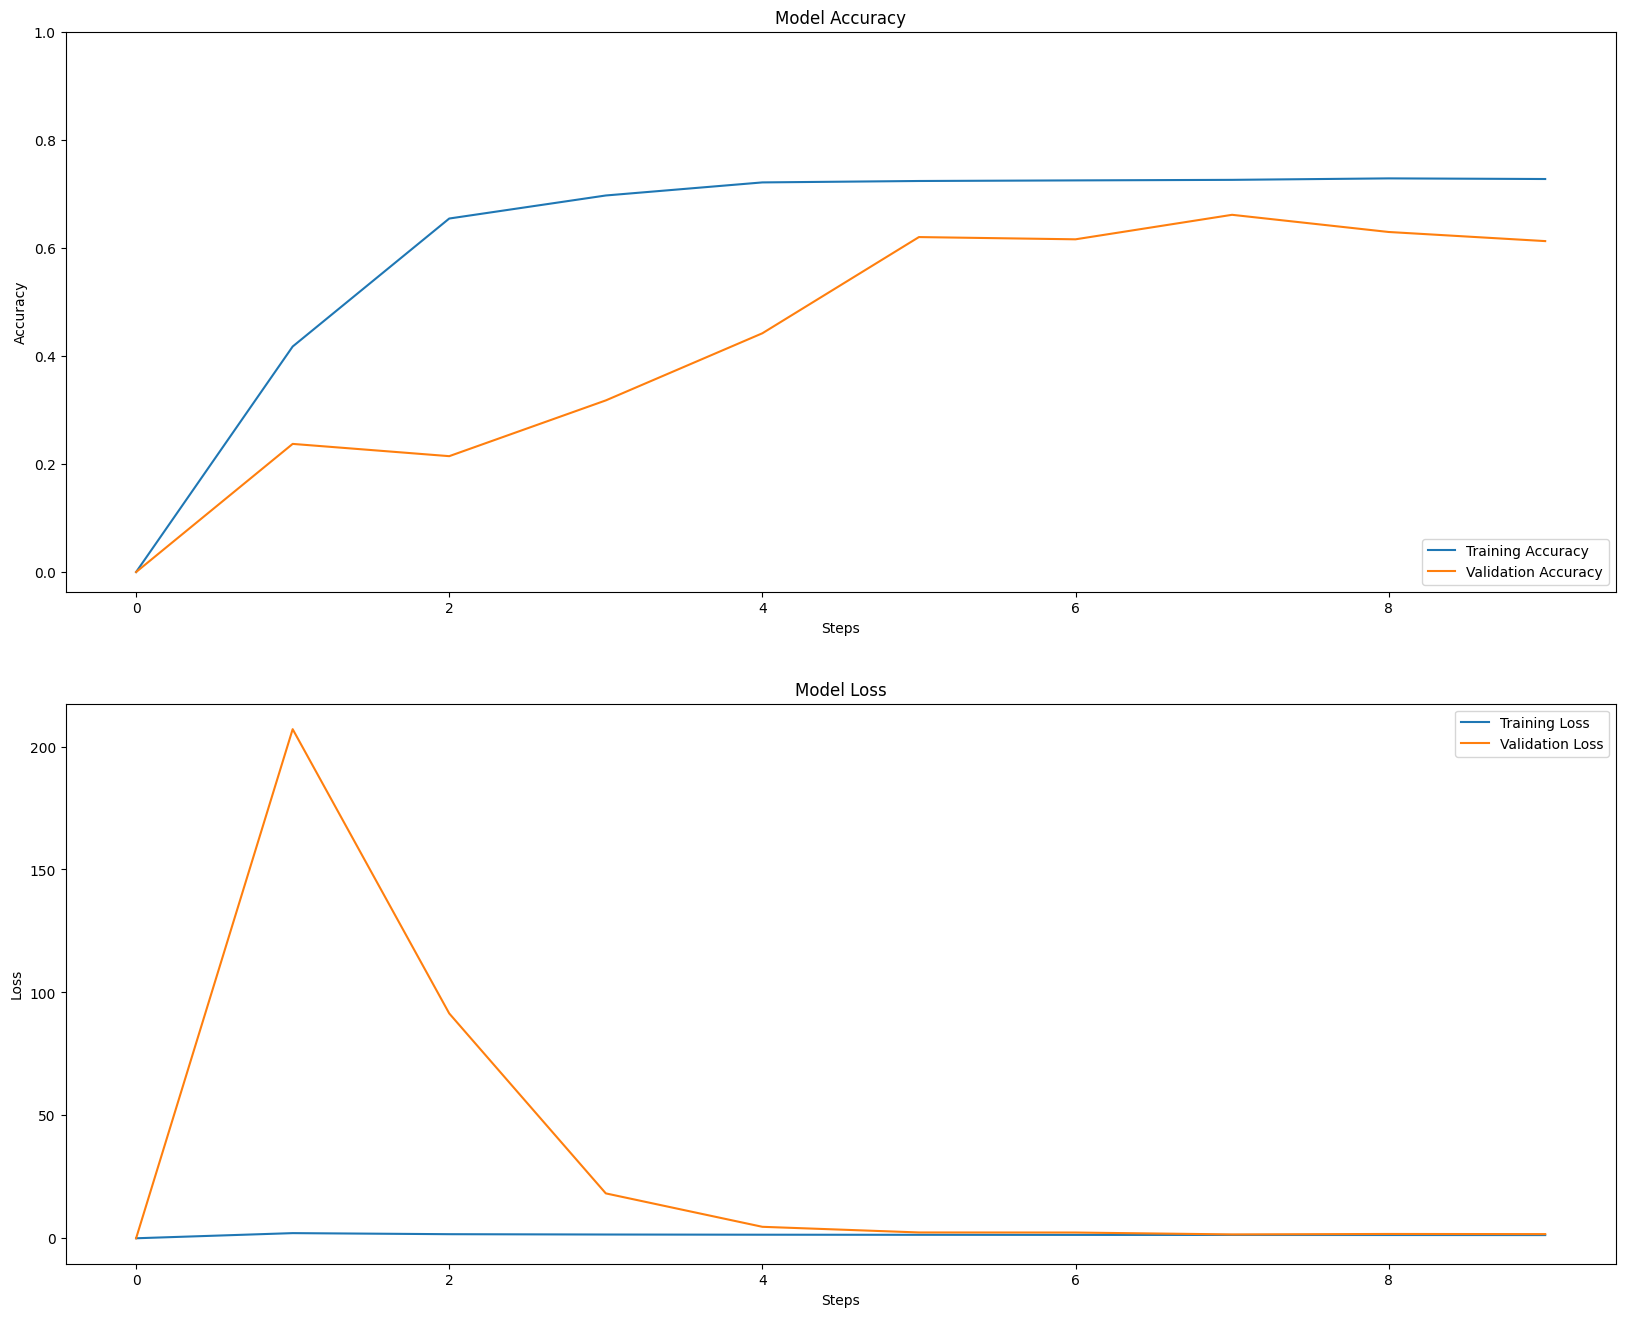

In [45]:
plot_history(history)

In [57]:
unet_model = tf.keras.models.load_model("unet-carla-segmentation.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 90 variables whereas the saved optimizer has 178 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [47]:
train_loss, train_acc = unet_model.evaluate(train_dataset, batch_size = 64)
val_loss, val_acc = unet_model.evaluate(val_dataset, batch_size = 64)
test_loss, test_acc = unet_model.evaluate(test_dataset, batch_size = 64)

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - accuracy: 0.6181 - loss: 1.6830
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.6153 - loss: 1.6822
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.6116 - loss: 1.6898


In [48]:
print("Training Dataset accuracy: ", format(train_acc*100, '.2f'))
print("Validation Dataset accuracy: ", round(val_acc*100, 2))
print(f"Test Dataset accuracy: {test_acc*100: .2f}")

Training Dataset accuracy:  61.81
Validation Dataset accuracy:  61.25
Test Dataset accuracy:  61.16


In [49]:
def iou_score(model, dataset):
    intersections, unions, min_ious, max_ious = [], [], [], []
    for image, mask in dataset:
        pred_mask = model.predict(image)
        intersection = np.logical_and(mask, pred_mask)
        union = np.logical_or(mask, pred_mask)
        intersection_sum = np.array([np.sum(inter) for inter in intersection])
        union_sum = np.array([np.sum(un) for un in union])

        batch_iou_score = intersection_sum/union_sum
        batch_min_iou = np.amin(batch_iou_score)
        batch_max_iou = np.amax(batch_iou_score)

        intersections.append(np.sum(intersection))
        unions.append(np.sum(union))
        min_ious.append(batch_min_iou)
        max_ious.append(batch_max_iou)

    min_iou = np.amin(min_ious)
    max_iou = np.amax(max_ious)
    mean_iou = np.sum(intersections)/np.sum(unions)

    return min_iou, max_iou, mean_iou

In [50]:
min_iou_train, max_iou_train, mean_iou_train = iou_score(unet_model, train_dataset)
min_iou_val, max_iou_val, mean_iou_val = iou_score(unet_model, val_dataset)
min_iou_test, max_iou_test, mean_iou_test = iou_score(unet_model, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [51]:
print("Min. IoU Score for Training Dataset: ", format(min_iou_train*100, '.2f'))
print("Max. IoU Score for Training Dataset: ", format(max_iou_train*100, '.2f'))
print("Mean IoU Score for Training Dataset: ", format(mean_iou_train*100, '.2f'))

print("Min. IoU Score for Validation Dataset: ", round(min_iou_val*100, 2))
print("Max. IoU Score for Validation Dataset: ", round(max_iou_val*100, 2))
print("Mean IoU Score for Validation Dataset: ", round(mean_iou_val*100, 2))

print(f"Min. IoU Score for Test Dataset: {min_iou_test*100: .2f}")
print(f"Max. IoU Score for Test Dataset: {max_iou_test*100: .2f}")
print(f"Mean IoU Score for Test Dataset: {mean_iou_test*100: .2f}")

Min. IoU Score for Training Dataset:  55.52
Max. IoU Score for Training Dataset:  84.90
Mean IoU Score for Training Dataset:  68.15
Min. IoU Score for Validation Dataset:  54.45
Max. IoU Score for Validation Dataset:  84.36
Mean IoU Score for Validation Dataset:  68.65
Min. IoU Score for Test Dataset:  58.67
Max. IoU Score for Test Dataset:  83.39
Mean IoU Score for Test Dataset:  69.42


In [52]:
def create_mask(mask):
    pred_mask = tf.argmax(mask, axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize = (15, 15))
    titles = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        plt.plot()

def show_preds(model, dataset = None, num = 3, sample_image = None, sample_mask = None):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    elif sample_image is not None and sample_mask is not None:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    else:
        print("Dataset Missing")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


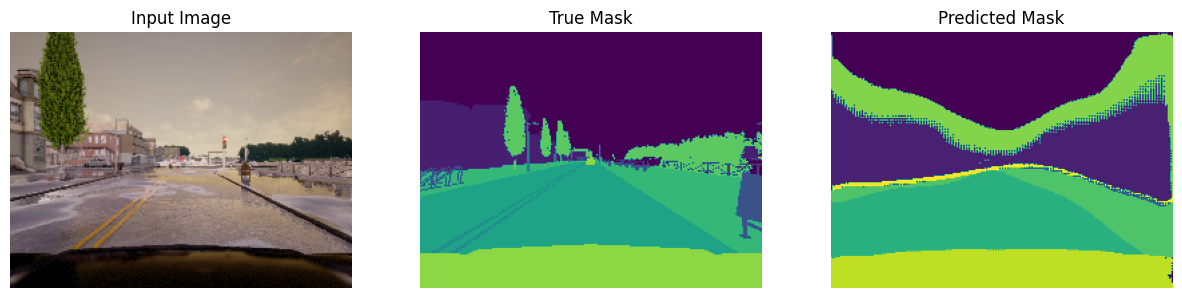

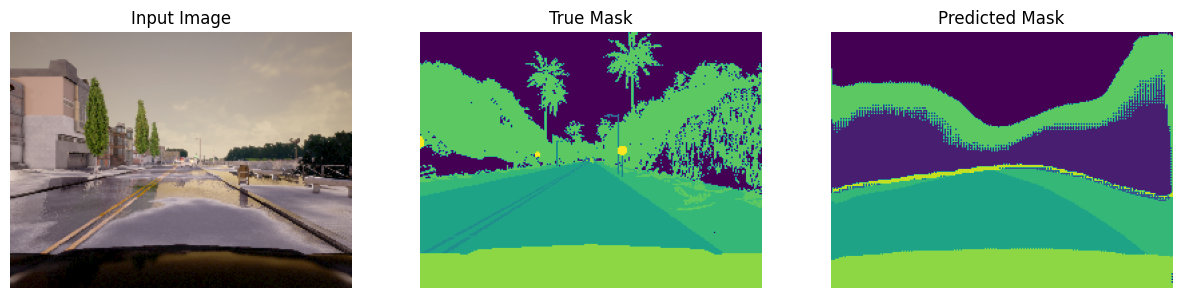

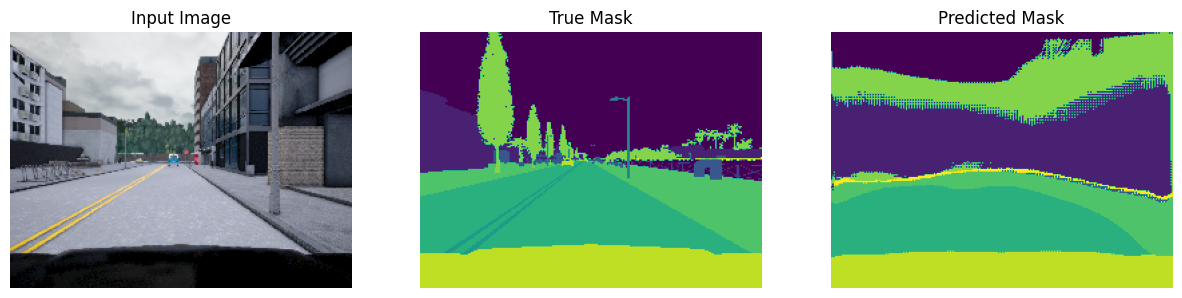

In [53]:
show_preds(unet_model, train_dataset, 3)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


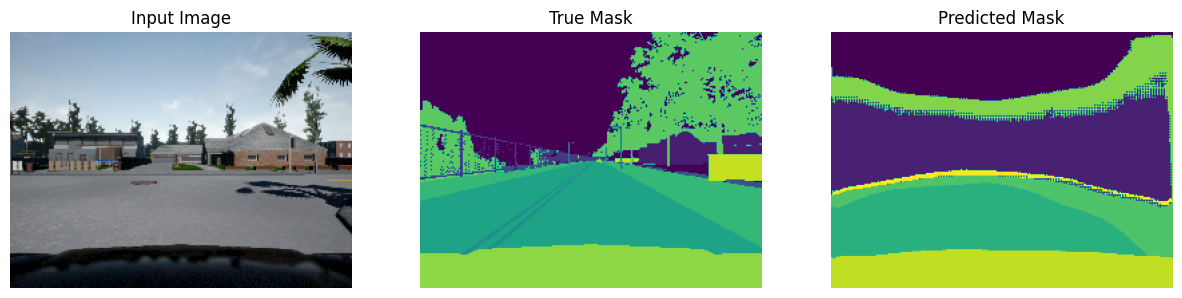

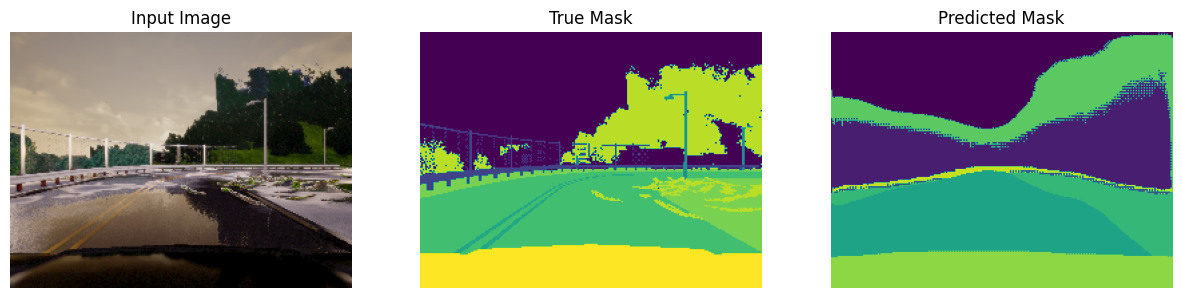

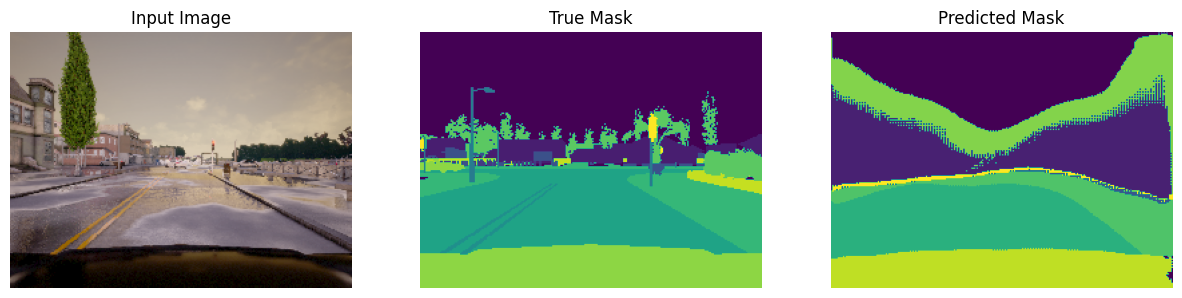

In [54]:
show_preds(unet_model, val_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


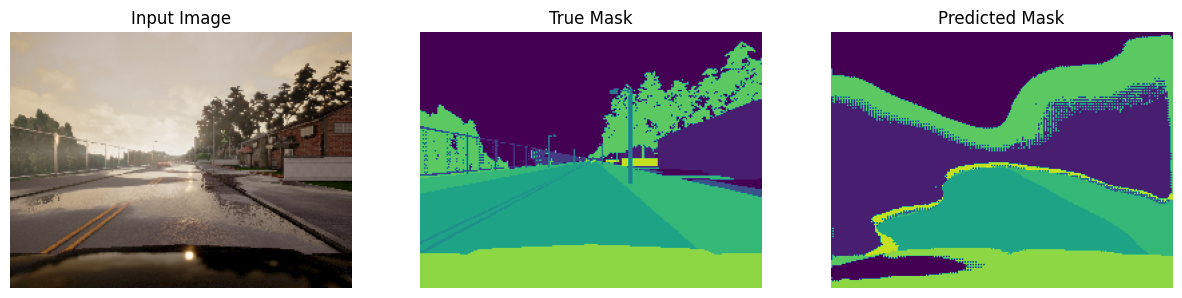

In [55]:
show_preds(unet_model, test_dataset)

In [56]:
def generate_mask(model, img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (192, 256), method = "nearest")

    sample_img = img[tf.newaxis, ...]
    pred_mask = model.predict(sample_img)
    pred_mask = create_mask(pred_mask)

    plt.figure(figsize = (10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
    plt.title('Sample Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[1:]))
    plt.axis('off')
    plt.title('Generated Mask')
    plt.plot()

    return img, pred_mask

In [ ]:
# img, mask = generate_mask(unet_model, '/kaggle/input/carlasample/Road Highway Traffic.jpg')

# show_preds(unet_model, sample_image = img, sample_mask = mask)
# The True and predicted mask will be the same as the mask is generated with the same model